# Text classification by neural network

## 1. Packages and necessary functions

In [1]:
import os
import pandas as pd
import string

import tensorflow as tf

import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
# plot confusion matrix
def plot_cm(y_true, y_pred, figsize=(15,15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## 2. Load data

In [4]:
raw_data = pd.read_csv('raw_data.csv')
raw_data.head(10)

,content,category
0,Võ sĩ MMA bị knock-out lạ kỳ vì... 'đụng đầu' ...,Thể thao
1,"Thi đấu từ máy bay ở độ cao 6.096m, ngôi sao 6...",Thể thao
2,Ấn Độ yêu cầu mạng xã hội gỡ cụm từ 'biến thể ...,Công nghệ
3,Tay đua 19 tuổi Jason Dupasquier qua đời sau t...,Thể thao
4,Cảnh sát Ấn Độ 'cảnh báo' Công ty Twitter TTO ...,Công nghệ
5,Sủng Cỏ thiên đường hoang sơ nơi cửa vịnh Đà N...,Du lịch
6,"Giận liên đoàn, CĐV Indonesia không vào sân cổ...",Thể thao
7,Google bỏ cookie theo dõi người dùng là để 'là...,Công nghệ
8,"Võ sĩ hạng nặng đánh nhau trên sàn đấu, khán g...",Thể thao
9,Bánh trứng thời nghèo khó Dan Bing bỗng len lỏ...,Du lịch


In [5]:
raw_data.groupby('category').size()

category
Công nghệ    1579
Du lịch      2535
Thể thao     3058
dtype: int64

## 3- Preprocessing data

### 3.1 - Cleanup text

In [6]:
contents = raw_data['content'].values
for i, content in enumerate(contents):
    s = content.lower().replace('\n', ' ')
    s = s.replace('"', ' ')
    s = s.replace("'", ' ')
    contents[i] = s
contents

array(['võ sĩ mma bị knock-out lạ kỳ vì...  đụng đầu  với đối thủ tto - trong lúc cố gắng tấn công, võ sĩ người nga kiril fomenkov vô tình đụng đầu với đối thủ và bị knock-out một cách kỳ lạ ở trận so tài với aleksandr yakovenko ngày 30-5, tại sự kiện eagle fighting championship của nga.',
       'thi đấu từ máy bay ở độ cao 6.096m, ngôi sao 6.000 lần nhảy dù tử nạn tto - ngôi sao nhảy dù 30 tuổi dimitri didenko đã tử nạn ngày 15-3, sau khi rơi từ độ cao 20.000 ft (6.096m) trong lúc đang thi đấu ở giải vô địch nhảy dù úc 2021. chiếc dù của anh gặp sự cố không thể mở ra được trong lúc thi đấu. qua điều tra, cảnh sát úc kết luận đây là một tai nạn và  gây ớn lạnh  cho tất cả những người đã chứng kiến. cảnh sát úc cho biết cụ thể:   trong khoảng thời gian từ 13h chiều đến 14h30, người đàn ông đã nhảy từ một chiếc máy bay và người ta tin rằng chiếc dù của anh ấy đã không được mở đúng cách khiến anh ấy rơi xuống đất. anh ấy bị thương rất nặng và chết tại hiện trường, dù đội cứu thương đã cố

In [7]:
categories = raw_data['category'].values
for i, category in enumerate(categories):
    categories[i] = category.lower()
categories

array(['thể thao', 'thể thao', 'công nghệ', ..., 'du lịch', 'thể thao',
       'du lịch'], dtype=object)

In [8]:
raw_data

,content,category
0,võ sĩ mma bị knock-out lạ kỳ vì... đụng đầu ...,thể thao
1,"thi đấu từ máy bay ở độ cao 6.096m, ngôi sao 6...",thể thao
2,ấn độ yêu cầu mạng xã hội gỡ cụm từ biến thể ...,công nghệ
3,tay đua 19 tuổi jason dupasquier qua đời sau t...,thể thao
4,cảnh sát ấn độ cảnh báo công ty twitter tto ...,công nghệ
...,...,...
7167,ngắm ruộng bậc thang ngải thầu mùa nước đổ tto...,du lịch
7168,video: nữ tuyển thủ nhật ghi bàn thắng đẹp như...,thể thao
7169,"quyến rũ sa pa mùa nước đổ tto - tháng 5, bắt ...",du lịch
7170,tàu vận tải triều tiên chìm ngoài khơi nhật bả...,thể thao


### 3.2 - Tokenize

In [9]:
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP(address="http://127.0.0.1", port=8000)

** Example of how to use vncorenlp to tokenize text **

In [10]:
# Input 
text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

# To perform word segmentation, POS tagging, NER and then dependency parsing
annotated_text = annotator.annotate(text)
print(annotated_text)

print('------------------------------------------------------------------')

# To perform word segmentation only
word_segmented_text = annotator.tokenize(text)
print(word_segmented_text)

{'sentences': [[{'index': 1, 'form': 'Ông', 'posTag': 'Nc', 'nerLabel': 'O', 'head': 4, 'depLabel': 'sub'}, {'index': 2, 'form': 'Nguyễn_Khắc_Chúc', 'posTag': 'Np', 'nerLabel': 'B-PER', 'head': 1, 'depLabel': 'nmod'}, {'index': 3, 'form': 'đang', 'posTag': 'R', 'nerLabel': 'O', 'head': 4, 'depLabel': 'adv'}, {'index': 4, 'form': 'làm_việc', 'posTag': 'V', 'nerLabel': 'O', 'head': 0, 'depLabel': 'root'}, {'index': 5, 'form': 'tại', 'posTag': 'E', 'nerLabel': 'O', 'head': 4, 'depLabel': 'loc'}, {'index': 6, 'form': 'Đại_học', 'posTag': 'N', 'nerLabel': 'B-ORG', 'head': 5, 'depLabel': 'pob'}, {'index': 7, 'form': 'Quốc_gia', 'posTag': 'N', 'nerLabel': 'I-ORG', 'head': 6, 'depLabel': 'nmod'}, {'index': 8, 'form': 'Hà_Nội', 'posTag': 'Np', 'nerLabel': 'I-ORG', 'head': 6, 'depLabel': 'nmod'}, {'index': 9, 'form': '.', 'posTag': 'CH', 'nerLabel': 'O', 'head': 4, 'depLabel': 'punct'}], [{'index': 1, 'form': 'Bà', 'posTag': 'Nc', 'nerLabel': 'O', 'head': 9, 'depLabel': 'sub'}, {'index': 2, 'for

** Tokenized the document **

In [11]:
for i, content in enumerate(contents):
    word_segmented_text = annotator.tokenize(content)
    contents[i] = ' '.join(word_segmented_text[0])
contents

array(['võ_sĩ mma bị knock-out lạ_kỳ vì ... đụng_đầu với đối_thủ tto - trong lúc cố_gắng tấn_công , võ_sĩ người nga kiril fomenkov vô_tình đụng_đầu với đối_thủ và bị knock-out một_cách kỳ_lạ ở trận so tài với aleksandr yakovenko ngày 30-5 , tại sự_kiện eagle fighting championship của nga .',
       'thi_đấu từ máy_bay ở độ cao 6.096 m , ngôi_sao 6.000 lần nhảy_dù tử_nạn tto - ngôi_sao nhảy_dù 30 tuổi dimitri didenko đã tử_nạn ngày 15-3 , sau khi rơi từ độ cao 20.000 ft ( 6.096 m ) trong lúc đang thi_đấu ở giải vô_địch nhảy_dù úc 2021 . chiếc dù của anh gặp sự_cố không_thể mở ra được trong lúc thi_đấu . qua điều_tra , cảnh_sát úc kết_luận đây là một tai_nạn và gây ớn lạnh cho tất_cả những người đã chứng_kiến . cảnh_sát úc cho biết cụ_thể : trong khoảng thời_gian từ 13h chiều đến 14h30 , người đàn_ông đã nhảy từ một chiếc máy_bay và người ta tin rằng chiếc dù của anh ấy đã không được mở đúng cách khiến anh ấy rơi xuống đất . anh ấy bị_thương rất nặng và chết tại hiện_trường , dù đội cứu_

## 4. Split data into train - test sets

In [12]:
X = raw_data['content'].values
y = raw_data['category'].values

Since categories (label) are categorical variables, we need to convert categories into numbers.

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
X_train.shape

(5737,)

In [16]:
y_train.shape

(5737,)

In [17]:
X_test.shape

(1435,)

In [18]:
y_test.shape

(1435,)

## 5. tfidf

In [19]:
# vectorize X train data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
vocab = vectorizer.get_feature_names()

In [20]:
len(vocab)

18591

In [21]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train_tfidf = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_tfidf = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))

In [22]:
y_train_tfidf

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [23]:
# vectorize X test data
X_test_tfidf = vectorizer.transform(X_test).toarray()

## 6. Neural network

In [24]:
# hyperparameters
num_classes = 3 # Thể thao, du lịch, công nghệ
learning_rate = 0.001
epochs = 100
batch_size = 128

### 6.1. Two layers, first layer has 128 neurals

In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_dim=X_train_tfidf.shape[1], activation='relu'),
	tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [62]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [63]:
history = model.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
45/45 [==============================] - 2s 18ms/step - loss: 0.8902 - accuracy: 0.7643
Epoch 2/100
45/45 [==============================] - 1s 17ms/step - loss: 0.4359 - accuracy: 0.9189
Epoch 3/100
45/45 [==============================] - 1s 17ms/step - loss: 0.2433 - accuracy: 0.9440
Epoch 4/100
45/45 [==============================] - 1s 17ms/step - loss: 0.1617 - accuracy: 0.9615
Epoch 5/100
45/45 [==============================] - 1s 18ms/step - loss: 0.1126 - accuracy: 0.9775
Epoch 6/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0791 - accuracy: 0.9868
Epoch 7/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0564 - accuracy: 0.9915
Epoch 8/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0413 - accuracy: 0.9936
Epoch 9/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0307 - accuracy: 0.9967
Epoch 10/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0237 - accuracy: 0.9976

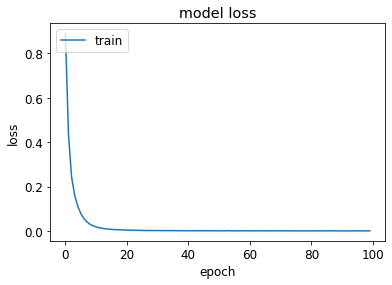

In [64]:
# summarize history for loss
plt.plot()
plt.plot(range(0, epochs), history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

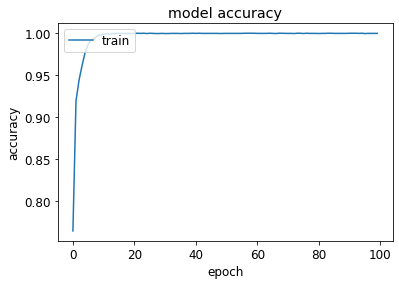

In [65]:
# summarize history for accuracy
plt.plot(range(0, epochs), history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
y_pred_prob = model.predict(X_test_tfidf)
y_pred = []
for item in y_pred_prob:
    m = max(item)
    for idx, val in enumerate(item):
        if val == m:
            y_pred.append(idx)
            break

In [67]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 88.22 %.


In [68]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[263,  62,  10],
       [ 27, 466,  20],
       [ 13,  37, 537]])

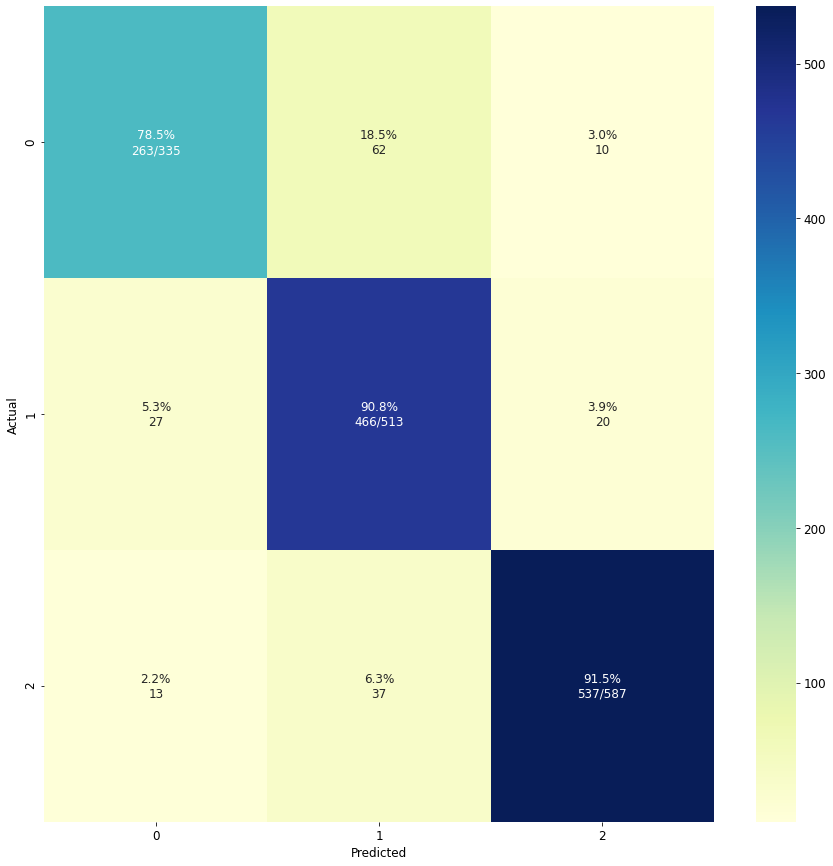

In [69]:
plot_cm(y_test, y_pred)

In [71]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.8679868 , 0.82477876, 0.94708995]),
 array([0.78507463, 0.90838207, 0.91482112]),
 array([0.82445141, 0.86456401, 0.93067591]),
 array([335, 513, 587]))

### 6.2. Two layers, first layer has 1024 neurals

In [26]:
epochs = 1000

In [72]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1024,input_dim=X_train_tfidf.shape[1], activation='relu'),
	tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model2.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history2 = model2.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
45/45 [==============================] - 4s 79ms/step - loss: 0.6338 - accuracy: 0.8100
Epoch 2/100
45/45 [==============================] - 4s 80ms/step - loss: 0.1894 - accuracy: 0.9442
Epoch 3/100
45/45 [==============================] - 4s 78ms/step - loss: 0.0769 - accuracy: 0.9833
Epoch 4/100
45/45 [==============================] - 4s 80ms/step - loss: 0.0320 - accuracy: 0.9949
Epoch 5/100
45/45 [==============================] - 4s 78ms/step - loss: 0.0154 - accuracy: 0.9981
Epoch 6/100
45/45 [==============================] - 4s 79ms/step - loss: 0.0093 - accuracy: 0.9991
Epoch 7/100
45/45 [==============================] - 4s 78ms/step - loss: 0.0070 - accuracy: 0.9990
Epoch 8/100
45/45 [==============================] - 4s 79ms/step - loss: 0.0059 - accuracy: 0.9990
Epoch 9/100
45/45 [==============================] - 4s 79ms/step - loss: 0.0049 - accuracy: 0.9991
Epoch 10/100
45/45 [==============================] - 4s 78ms/step - loss: 0.0038 - accuracy: 0.9995

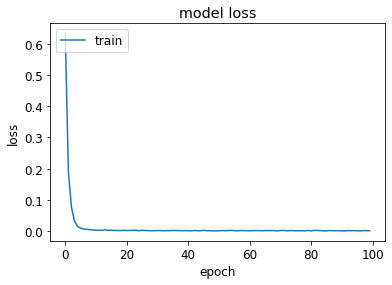

In [73]:
# summarize history for loss
plt.plot()
plt.plot(range(0, epochs), history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

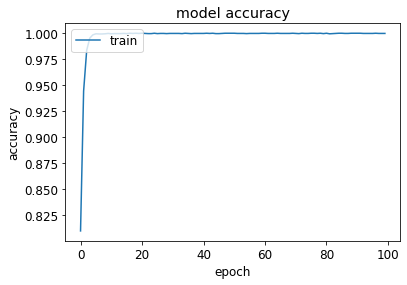

In [74]:
# summarize history for accuracy
plt.plot(range(0, epochs), history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
y_pred_prob = model2.predict(X_test_tfidf)
y_pred = []
for item in y_pred_prob:
    m = max(item)
    for idx, val in enumerate(item):
        if val == m:
            y_pred.append(idx)
            break

In [76]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 88.01 %.


In [77]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[268,  59,   8],
       [ 36, 459,  18],
       [ 11,  40, 536]])

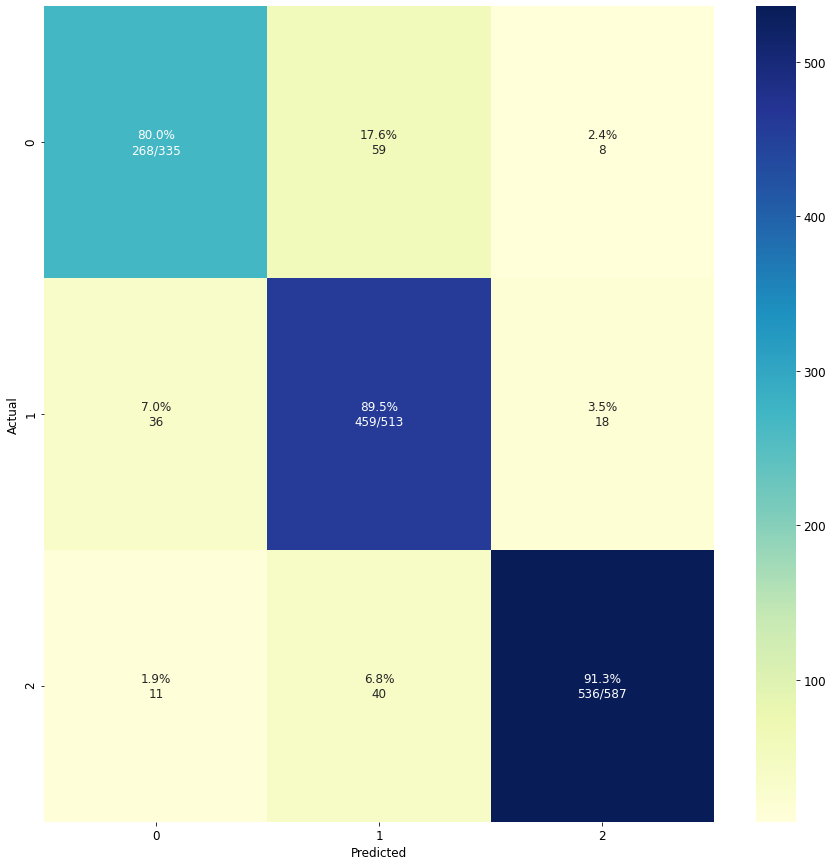

In [78]:
plot_cm(y_test, y_pred)

In [79]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.85079365, 0.82258065, 0.95373665]),
 array([0.8       , 0.89473684, 0.91311755]),
 array([0.82461538, 0.85714286, 0.9329852 ]),
 array([335, 513, 587]))

### 7.3. Many layers

In [80]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(200,input_dim=X_train_tfidf.shape[1], activation='relu'),
    tf.keras.layers.Dense(150,input_dim=X_train_tfidf.shape[1], activation='relu'),
    tf.keras.layers.Dense(100,input_dim=X_train_tfidf.shape[1], activation='relu'),
    tf.keras.layers.Dense(50,input_dim=X_train_tfidf.shape[1], activation='relu'),
	tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model3.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history3 = model3.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
45/45 [==============================] - 1s 25ms/step - loss: 0.7283 - accuracy: 0.6948
Epoch 2/100
45/45 [==============================] - 1s 25ms/step - loss: 0.1947 - accuracy: 0.9434
Epoch 3/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0560 - accuracy: 0.9841
Epoch 4/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0157 - accuracy: 0.9958
Epoch 5/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0045 - accuracy: 0.9991
Epoch 6/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0045 - accuracy: 0.9991
Epoch 7/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0038 - accuracy: 0.9990
Epoch 8/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0040 - accuracy: 0.9991
Epoch 9/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0024 - accuracy: 0.9993
Epoch 10/100
45/45 [==============================] - 1s 26ms/step - loss: 0.0023 - accuracy: 0.9995

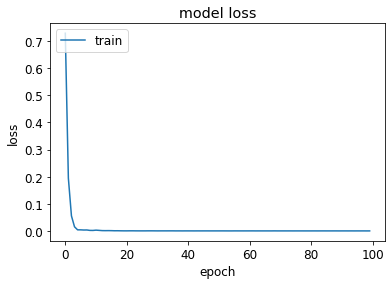

In [81]:
# summarize history for loss
plt.plot()
plt.plot(range(0, epochs), history3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

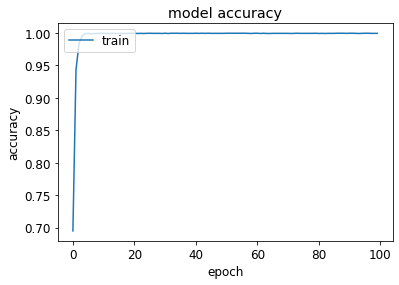

In [82]:
# summarize history for accuracy
plt.plot(range(0, epochs), history3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
y_pred_prob = model3.predict(X_test_tfidf)
y_pred = []
for item in y_pred_prob:
    m = max(item)
    for idx, val in enumerate(item):
        if val == m:
            y_pred.append(idx)
            break

In [84]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 87.74 %.


In [85]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[269,  57,   9],
       [ 36, 457,  20],
       [ 15,  39, 533]])

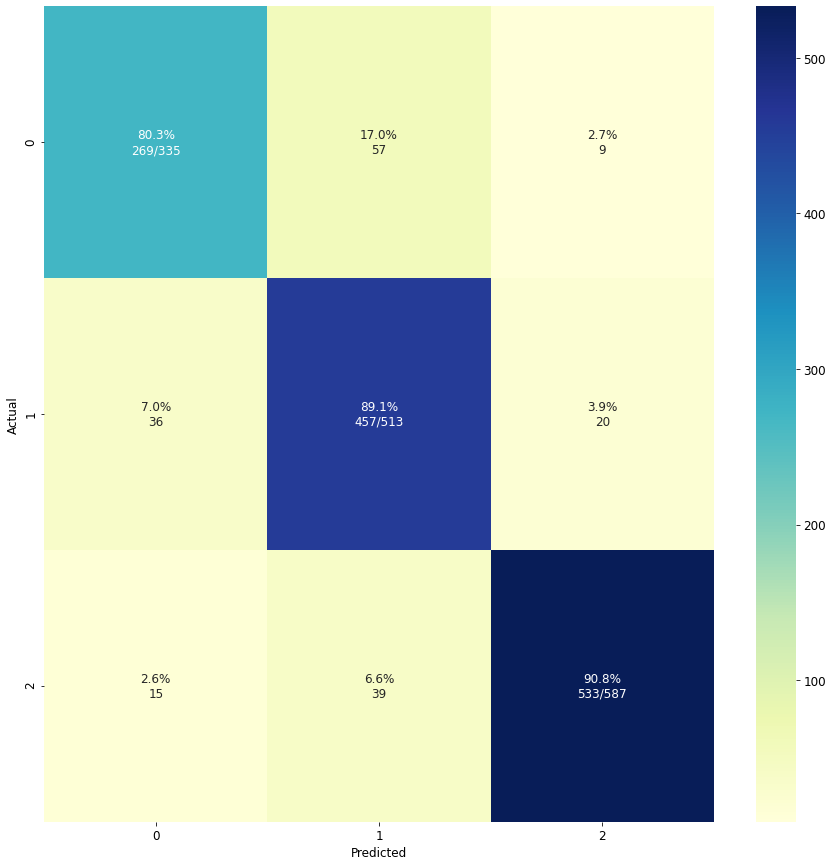

In [86]:
plot_cm(y_test, y_pred)

In [87]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.840625  , 0.82640145, 0.94839858]),
 array([0.80298507, 0.89083821, 0.90800681]),
 array([0.82137405, 0.85741088, 0.92776327]),
 array([335, 513, 587]))